# Tutorial for BilinearModels package

## Introduction

Generalized bilinear models (GBMs) are a flexible extension of generalized linear models (GLMs) to include latent factors as well as row covariates, column covariates, and interactions to analyze matrix data (Choulakian, 1996; Miller and Carter, 2020).

This tutorial shows how to use the [BilinearModels.jl](https://github.com/jwmi/BilinearModels.jl) Julia package to perform estimation and inference in negative binomial GBMs for count data.  Please cite [Miller and Carter (2020)](#references) if you use the BilinearModels.jl package for research leading to a publication.

In a GBM, the data matrix $Y = (Y_{i j})\in\mathbb{R}^{I\times J}$ is modeled by parametrizing the mean matrix $\mathrm{E}(Y)$ such that

$$ g(\mathrm{E}(Y)) = X A^\texttt{T} + B Z^\texttt{T} + X C Z^\texttt{T} + U D V^\texttt{T} \tag{1} $$

where $X\in\mathbb{R}^{I\times K}$ and $Z\in\mathbb{R}^{J\times L}$ are matrices of covariates and 
$g$ is a link function that is applied element-wise. The "bilinear" part $U D V^\texttt{T}$ is a rank $M$ matrix that captures latent effects due, for example, to unobserved covariates such as batch.  The BilinearModels.jl package implements a negative binomial outcome with log link, $g(\mu) = \log(\mu)$, specifically,

$$ Y_{i j} \sim \mathrm{NegBin}(\mu_{i j}, r_{i j}) $$

where $\mu_{i j} = \mathrm{E}(Y_{i j})$ is the mean and $1/r_{i j}$ is the dispersion, which we parametrize as $1/r_{i j} = \exp(s_i+t_j+\omega)$.  See [Miller and Carter (2020)](#references) for details.

<!-- <br><center><img src="https://github.com/jwmi/BilinearModelsExamples/raw/main/tutorial/figures/model-g.png" width="800"></center> -->

<br>
<div>
<!-- <img src="figures/model-g.png" align="center" width="800"/> -->
<img src="https://github.com/jwmi/BilinearModelsExamples/raw/main/tutorial/figures/model-g.png" align="center" width="800"/>
</div>

The package provides two main functions: `fit` and `infer`.  The `fit` function takes $Y$, $X$, $Z$, and $M$ as inputs, and returns estimates of all the parameters ($A$, $B$, $C$, $D$, $U$, $V$, $S$, $T$, and $\omega$).  The `infer` function takes $Y$, $X$, $Z$, and the parameter estimates as inputs, and returns approximate standard errors.


***
## Setup

### Installing the BilinearModels.jl package

First, download and install [Julia](https://julialang.org/).  Start Julia and enter the following commands at the `julia>` prompt to install the [BilinearModels.jl](https://github.com/jwmi/BilinearModels.jl) package:

In [ ]:
using Pkg
Pkg.add(url="https://github.com/jwmi/BilinearModels.jl")

In [1]:
using BilinearModels

As a quick test to make sure things are working, try this:

In [5]:
Y = [1 2 3; 4 5 6; 7 8 0]
I,J = size(Y)
X = ones(I,1)
Z = ones(J,1)
A,B,C,D,U,V,S,T,omega,logp = BilinearModels.fit(Y,X,Z,0)
A

iteration 1: logp = -32.181561516520645
iteration 2: logp = -32.06094964489715
iteration 3: logp = -32.02450562203871
iteration 4: logp = -32.00936718102702
iteration 5: logp = -32.002571675212614
iteration 6: logp = -31.999367910889188
iteration 7: logp = -31.997817594791158
iteration 8: logp = -31.997057070632096
iteration 9: logp = -31.99668136745074
iteration 10: logp = -31.996495098807483
iteration 11: logp = -31.996402577578284
iteration 12: logp = -31.996356577164565
iteration 13: logp = -31.99633369482534
Finished.


3×1 Array{Float64,2}:
 -0.11118582286764742
  0.11506609564808493
 -0.0038802727804375103

### Installing other packages for the tutorial

We will also use some other Julia packages in this tutorial.  To install these, do:

In [5]:
using Pkg
Pkg.add(["Statistics","CSV","RData","GLM","PyPlot"])

  Resolving package versions...
No Changes to `C:\Users\jwmil\.julia\environments\v1.5\Project.toml`
No Changes to `C:\Users\jwmil\.julia\environments\v1.5\Manifest.toml`


### Loading example data

As a running example, we will use 412 RNA-seq samples from heart tissue provided by the [Recount2 project](https://jhubiostatistics.shinyapps.io/recount/) (Collado-Torres et al., 2017), originally collected as part of the Genotype-Tissue Expression (GTEx) project (Melé et al., 2015).

Download the following files to a folder on your computer:
- [Sample information file (344 KB)](https://github.com/jwmi/BilinearModelsExamples/raw/main/tutorial/gtex_sample_info-heart.txt)
- [Gene information file (2 MB)](https://github.com/jwmi/BilinearModelsExamples/raw/main/tutorial/gtex_gene_info-heart.txt)
- [Data file (15.7 MB)](https://github.com/jwmi/BilinearModelsExamples/raw/main/tutorial/gtex_data-heart.rda)
- [Miscellaneous helper functions](https://github.com/jwmi/BilinearModelsExamples/raw/main/tutorial/helper.jl)

In this data set, there is a row for each gene (i.e., each feature) and a column for each sample. To load these data, do:

In [2]:
cd("C:\\Users\\jwmil\\gdrive\\BilinearModelsExamples\\tutorial")  # change directory to the location of these files

include("helper.jl")  # load helper functions into Julia


In [3]:
sample_info = CSV.read("gtex_sample_info-heart.tsv"; delim='\t')  # load sample information file

,project,sample,experiment,run,read_count_as_reported_by_sra,reads_downloaded
,String,String,String,String,Int64,Int64
1,SRP012682,SRS333474,SRX199032,SRR606939,189907530,170497100
2,SRP012682,SRS648313,SRX629479,SRR1468613,119736648,119736648
3,SRP012682,SRS408501,SRX260988,SRR815184,115367100,115367100
4,SRP012682,SRS634869,SRX591515,SRR1381693,109208494,109208494
5,SRP012682,SRS648280,SRX629144,SRR1467904,96421614,96421614
6,SRP012682,SRS644516,SRX617942,SRR1442648,95958592,95958592
7,SRP012682,SRS649562,SRX636407,SRR1486174,94014668,94014668
8,SRP012682,SRS629385,SRX576409,SRR1349433,91835392,91835392
9,SRP012682,SRS625582,SRX563501,SRR1321283,90353688,90353688


In [4]:
gene_info = CSV.read("gtex_gene_info-heart.tsv"; delim='\t')  # load gene information file

,gene_id,symbol,seq_len,seqname,strand,num_A,num_C,num_G,num_T
,String,String,Int64,String,String,Int64,Int64,Int64,Int64
1,ENSG00000000003.14,TSPAN6,4535,chrX,-,1280,835,1054,1366
2,ENSG00000000005.5,TNMD,1610,chrX,+,492,334,350,434
3,ENSG00000000419.12,DPM1,1207,chr20,-,362,210,270,365
4,ENSG00000000457.13,SCYL3,6883,chr1,-,2058,1432,1416,1977
5,ENSG00000000460.16,C1orf112,5967,chr1,+,1647,1354,1211,1755
6,ENSG00000000938.12,FGR,3474,chr1,-,768,973,1018,715
7,ENSG00000000971.15,CFH,8145,chr1,+,2685,1349,1595,2516
8,ENSG00000001036.13,FUCA2,2793,chr6,-,796,576,637,784
9,ENSG00000001084.10,GCLC,8463,chr6,-,2319,1822,1904,2418


In [6]:
Y = load("gtex_data-heart.rda")["counts"]  # load data matrix

20088×412 Array{Int32,2}:
  182   179    412   133   141    282  …    304  211    381    215   253  151
    4     5      1     1     4      5         4    2      3      1     3    6
  561   574    534   490   375    758       700  673    505    610   522  559
  293   263    334   218   178    137       354  201    209    292   201  206
  137   124    213    99    95     55       157   96    146    176    97   89
  127   281    834   146   424    169  …    438   54    107    227   270  158
  732  1073  34158   376  1394  25192     12049  722  18834  19327  5649  567
 1147  1211    979  1011   599    882      1385  694    903    641   873  865
  772   549    621   474   244    498       528  382    477    481   521  557
  350   399    783   333   361    399       457  225    836    592   339  267
  136   123    254   123    87     85  …    169  119    160    101    63   70
 1023  1056    607  1041   288    642      1243  537    331    397   462  794
  582   546    765   617   563   1058 

In [7]:
I,J = size(Y)  # dimensions of data matrix

(20088, 412)

***


## Simple normalization

GBMs can be used for a wide range of tasks.  We first illustrate performing a simple normalization.
Count data are often preprocessed using a transformation such as $\log(Y_{i j}+1)$ and standardizing the rows and columns.
Instead, a model-based approach to normalizing count matrices is to use a negative binomial outcome model with

$$ \log(\mathrm{E}(Y_{i j})) = a_{j 1} + b_{i 1} + c_{1 1}, \tag{2} $$

which is a special case of a GBM.  The residuals from this model can be used for downstream analyses such as visualization with principal components analysis (PCA).

We illustrate on the GTEx heart data.  First, define $X$, $Z$, and $M$ as follows.  With these choices, the general GBM in Eqn (1) reduces to the simple normalization model in Eqn (2).

In [8]:
X = ones(I,1)  # feature covariate matrix is a column of ones (i.e., intercepts only)
Z = ones(J,1)  # sample covariate matrix is a column of ones (i.e., intercepts only)
M = 0;         # no latent factors

Then, to estimate the model parameters and compute the residuals, run:

In [9]:
A,B,C,D,U,V,S,T,omega,logp = BilinearModels.fit(Y,X,Z,M);  # fit the model
Eps,Sigma_Eps = BilinearModels.residuals(Y,X,Z,A,B,C,D,U,V,S,T,omega);  # compute the residuals

max step size enforced in S[i] update for one or more i.
max step size enforced in A[j,:] update for one or more j.
max step size enforced in S[i] update for one or more i.
iteration 1: logp = -4.608420742165705e7
iteration 2: logp = -4.601634813863698e7
iteration 3: logp = -4.600170494856905e7
iteration 4: logp = -4.599710814322703e7
iteration 5: logp = -4.599625286131605e7
iteration 6: logp = -4.5996207168753944e7
Finished.


In [10]:
Eps   # residuals (in log space)

20088×412 Array{Float64,2}:
 -0.265878   -0.222579     0.158723   …  -0.261669    0.149624   -0.285064
 -0.238001    0.038972    -1.92932       -1.6996     -0.429321    0.324711
 -0.0818612   0.00095037  -0.523208      -0.160458   -0.0675861   0.0819674
  0.107937    0.0598756   -0.153179      -0.0577972  -0.182423   -0.0767797
  0.0833096   0.0436139    0.132263       0.171293   -0.175273   -0.180144
 -0.69683     0.156707     0.79235    …  -0.278818    0.143196   -0.311216
 -2.23581    -1.79352      1.21497        0.87519    -0.106189   -2.32378
  0.2872      0.401399    -0.263188      -0.456907    0.100576    0.172459
  0.388704    0.107792    -0.220943      -0.246633    0.0818593   0.229746
 -0.13166     0.0592329    0.28131        0.231451   -0.0772693  -0.234834
  0.0290624  -0.0114029    0.261282   …  -0.430471   -0.653082   -0.466833
  0.314654    0.406307    -0.599261      -0.794029   -0.393816    0.228677
 -0.212182   -0.216112    -0.330861       0.236213    0.168179   -0.026

Here, the GBM residuals are defined as $\varepsilon_{i j} = \log(Y_{i j} + \epsilon) - \log(\mathrm{E}(Y_{i j}))$ where $\epsilon$ is a small constant to make the logarithm finite; the package uses $\epsilon = 1/8$ as a default.
The `residuals` function also returns `Sigma_Eps`, which is the estimated standard deviation of each entry of the residual matrix `Eps`.  Using `Sigma_Eps` enables one to account for the uncertainty in `Eps` by weighting the residuals according to their precision.

The residuals can be visualized using PCA. In this data, there are two clear clusters of samples, corresponding to subtissue type ("Heart - Atrial Appendage" and "Heart - Left Ventricle").  Subtissue type is indicated by the `smtsd` variable in the sample information file for this data set.

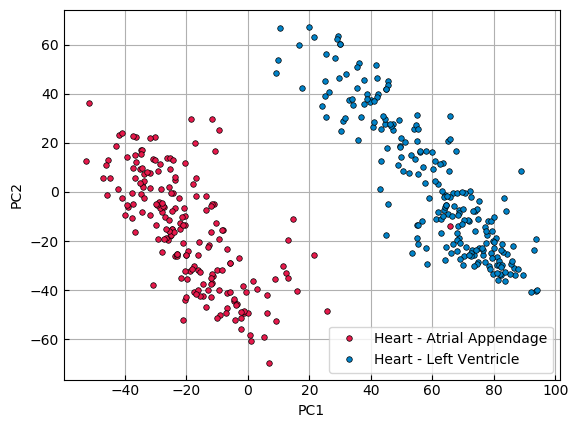

In [27]:
figure(); clf(); grid(true)
scores = pcaplot(Eps',sample_info[!,:smtsd]; ms=4, mec="k")
legend();

For comparison, running PCA on the log-transformed TPMs does not appear to be as clean:

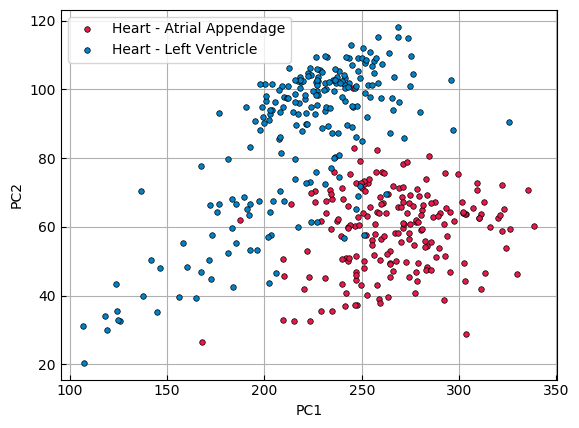

In [12]:
# Compute standard normalizations for comparison
RPM, RPKM, TPM = standard_normalizations(Y, gene_info[!,:seq_len])

figure(); clf(); grid(true)
pcaplot(log.(TPM.+1)',sample_info[!,:smtsd]; ms=4, mec="k")
legend();

***
## Exploring sample covariates using residuals

To explore relationships in the data, it is useful to color PCA plots using a variety of covariates.  We illustrate coloring this plot using two categorical covariates (`smcenter` = sample collection center, and `sex` = sex of the subject) and two numeric covariates (`age_numeric` = subject age coded as range midpoint, and `smrin` = RNA integrity number).

One must be careful to avoid finding spurious relationships, so in practice we recommend splitting the data into an exploratory subset and a testing subset (e.g., see Miller and Carter, 2020).  That way, one can inspect any number of plots like this using the exploratory subset, select a model based on this exploratory phase, and then perform statistically valid hypothesis tests on the testing data.

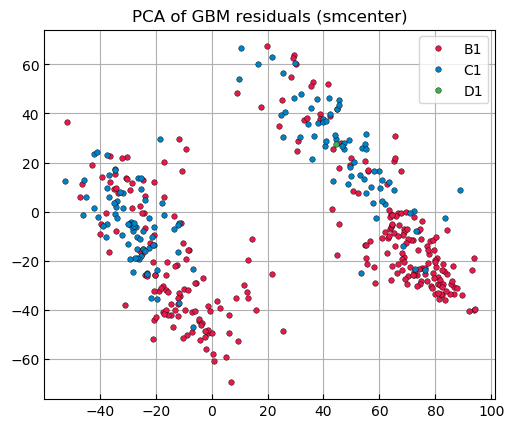

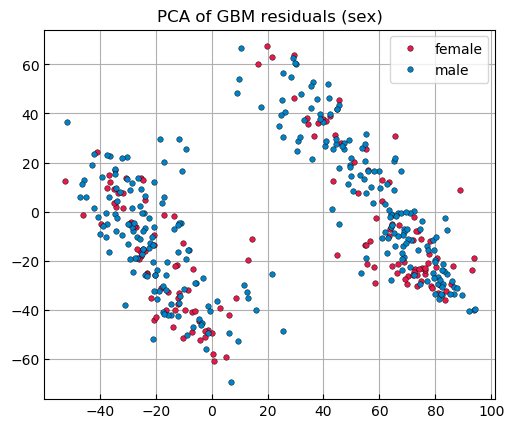

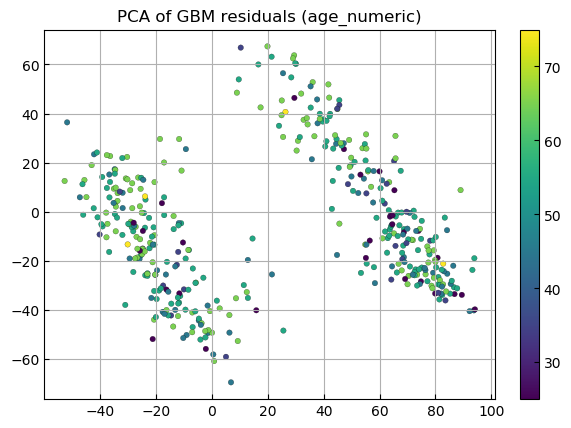

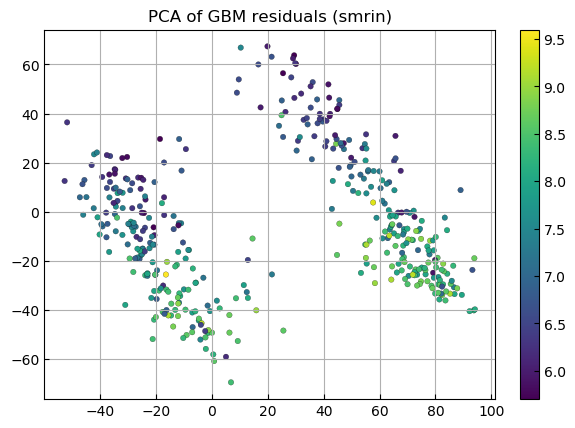

In [32]:
# Visualize association with sample covariates
colorbycategory = [:smcenter,:sex]
colorbynumeric = [:age_numeric,:smrin]
fignum = 0
for colorby in [colorbycategory; colorbynumeric]
    figure(fignum+=1); clf(); grid(true)
    colorvalue = sample_info[!,colorby]
    if colorby in colorbycategory
        plotgroups(scores[:,1], scores[:,2], string.(colorvalue); ms=4, mec="k", mew=0.3)
        subplots_adjust(right=0.83)
        legend()
    else
        scatter(scores[:,1], scores[:,2], 16, c=colorvalue; edgecolor="k", linewidth=0.15)
        subplots_adjust(right=0.9)
        colorbar(fraction=0.04)
    end
    title("PCA of GBM residuals ($(string(colorby)))")
end

***
## Adjusting for sample covariates

Often, there are unwanted sources of variation that one would like to remove, such as technical biases.
In the PCA plots of the residuals for the simple normalization model in Eqn (2), there is clearly some association with `smcenter` and `smrin` which could be due to technical batch effects.  Since the `smrin` association seems clearer and provides a plausible explanation for the `smcenter` effect (different centers might yield different quality samples), we consider adjusting for `smrin` as an example.

To add sample covariates to a GBM, we simply add columns to the $Z$ matrix.  That said, it is important to note that every additional sample covariate increases the dimension of the parameter space by $I$, since $Z\in\mathbb{R}^{J\times L}$ and $B\in\mathbb{R}^{I\times L}$. Thus, one must be judicious in the choice of which sample covariates to include, since otherwise overfitting can occur when $I$ is large and $J$ is small.

The code below includes `smrin` as a sample covariate. The `@formula` syntax from the `GLM` package provides a convenient way to specify design matrices, similar to the formulas used with `lm` in the R programming language. Here, the dependent variable `sampid` (sample ID) used in the formula is just a column of `sample_info` that contains a unique identifier for each row.

In [14]:
X = ones(I,1)
Z,Znames = design_matrix(@formula(sampid ~ 1 + smrin), sample_info)
M = 0;

In [15]:
A,B,C,D,U,V,S,T,omega,logp = BilinearModels.fit(Y,X,Z,M)
Eps_smrin,Sigma_Eps_smrin = BilinearModels.residuals(Y,X,Z,A,B,C,D,U,V,S,T,omega);

max step size enforced in S[i] update for one or more i.
max step size enforced in A[j,:] update for one or more j.
max step size enforced in S[i] update for one or more i.
iteration 1: logp = -4.566631368839498e7
iteration 2: logp = -4.560345322718896e7
iteration 3: logp = -4.5588987159105256e7
iteration 4: logp = -4.558238664084925e7
iteration 5: logp = -4.55786814255822e7
iteration 6: logp = -4.557684193768952e7
iteration 7: logp = -4.557625200195418e7
iteration 8: logp = -4.557616384719095e7
iteration 9: logp = -4.5576159680228785e7
Finished.


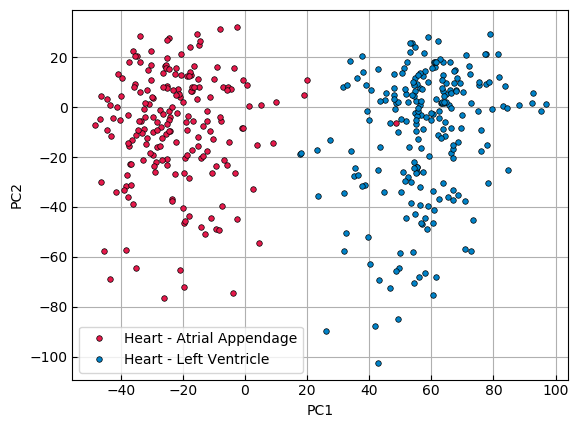

In [16]:
figure(); clf(); grid(true)
pcaplot(Eps_smrin',sample_info[!,:smtsd]; ms=4, mec="k")
legend();

After adjusting for `smrin` (RNA integrity number), the first PC clearly separates the samples by subtissue type.

***
## Exploring feature covariates using residuals

Similarly, we can explore possible associations with feature covariates using the model residuals.  To illustrate this, we start again with the residuals from the simple normalization model in Eqn (2).

To visualize each gene as a point, we could perform PCA on `Eps` instead of `Eps'` and plot the top two PCs as usual.  However, the figure below shows that this yields a highly skewed scatterplot.  To understand why, we color each gene using its log-transformed mean precision across samples, which makes it clear that the widely varying precision across genes is the reason for the skewness.

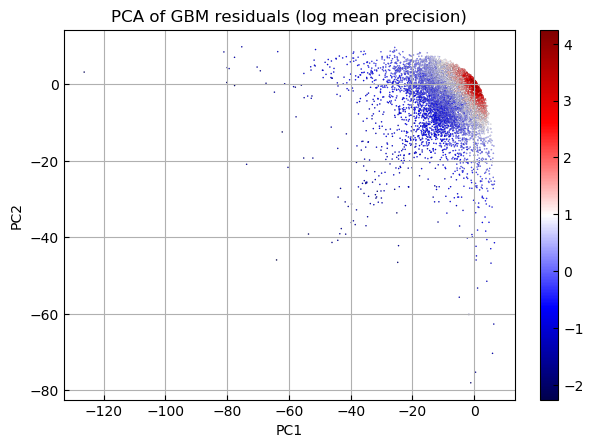

In [25]:
figure(); clf(); grid(true)
W = 1.0./Sigma_Eps.^2
log_mean_precision = log.(mean(W,dims=2))
pcaplot(Eps, log_mean_precision; numeric=true, s=1, edgecolor="k", linewidth=0.05, cmap="seismic")
colorbar(fraction=0.04)
title("PCA of GBM residuals (log mean precision)");

To fix this, we instead perform PCA on `Eps./Sigma_Eps`.

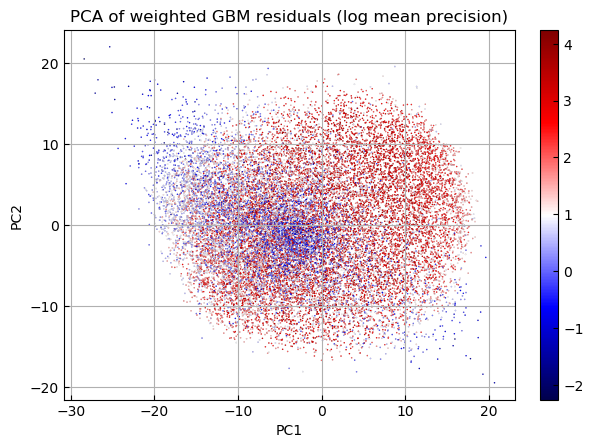

In [43]:
figure(); clf(); grid(true)
scores_gene = pcaplot(Eps./Sigma_Eps, log_mean_precision; numeric=true, s=1, edgecolor="k", linewidth=0.05, cmap="seismic")
colorbar(fraction=0.04)
title("PCA of weighted GBM residuals (log mean precision)");

Now, using the weighted residuals, we explore a few possible gene covariates.  First, we augment `gene_info` to add a couple more variables, then we plot them.

In [60]:
# Augment gene_info
gene_info[!,:GC_content] = gene_info[!,:pct_gc]
gene_info[!,:GC_squared] = moment2(gene_info[!,:GC_content]);  # square of GC content after centering
gene_info[!,:log_length] = log.(gene_info[!,:seq_len])  # log of the sum of the exon lengths for each gene

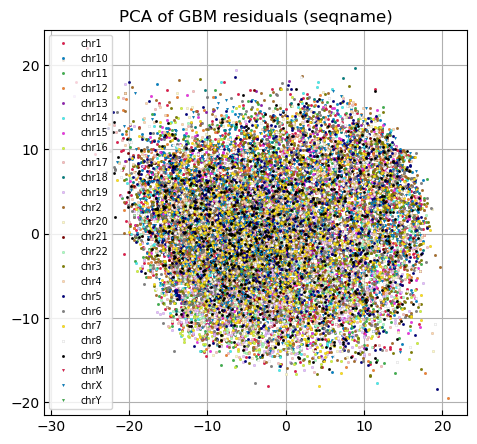

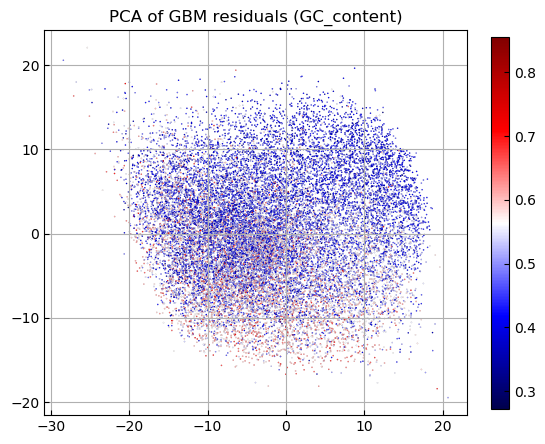

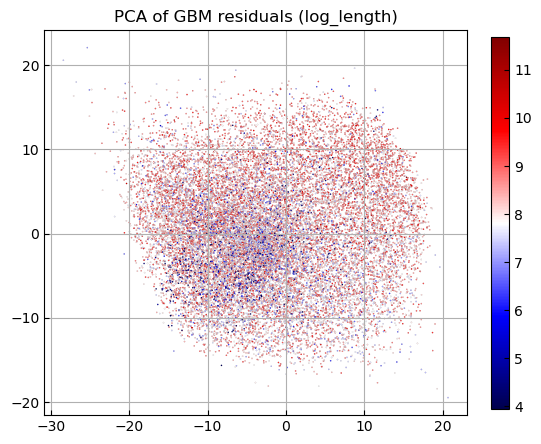

In [73]:
# Visualize association with feature covariates
colorbycategory = [:seqname]
colorbynumeric = [:GC_content,:log_length]
fignum = 0
for colorby in [colorbycategory; colorbynumeric]
    figure(fignum+=1,figsize=(6,5)); clf(); grid(true)
    colorvalue = gene_info[!,colorby]
    if colorby in colorbycategory
        plotgroups(scores_gene[:,1], scores_gene[:,2], string.(colorvalue); ms=2, mec="k", mew=0.05)
        subplots_adjust(right=0.83)
        legend(fontsize=7)
    else
        scatter(scores_gene[:,1], scores_gene[:,2], 1, c=colorvalue; edgecolor="k", linewidth=0.05, cmap="seismic")
        subplots_adjust(right=0.9)
        colorbar(fraction=0.04)
    end
    title("PCA of GBM residuals ($(string(colorby)))")
end

Visually, GC content appears to have a moderate association with PC2, which can be verified quantitatively:

In [78]:
cor(scores_gene, gene_info[!,:GC_content])

2×1 Array{Float64,2}:
 -0.1053559639996449
 -0.3894242515730471

***
## Adjusting for feature covariates

In sequencing data, there are often technical biases associated with feature covariates such as GC content. To add feature covariates to a GBM, we simply add columns to the $X$ matrix. 

As in the case of sample covariates, one needs to be careful not to overfit.  Fortunately, though, in the case of feature covariates, overfitting is less of an issue when $I$ is large relative to $J$, because the dimension of the parameter space only increases by $J$ with each additional feature covariate.

Here, we illustrate adjusting for `GC_content` and `GC_squared`.

<a id='references'></a>

## References

Choulakian, V. **Generalized bilinear models.** Psychometrika, 61(2):271–283, 1996.

Collado-Torres, L., Nellore, A., Kammers, K., Ellis, S. E., Taub, M. A., Hansen, K. D., Jaffe, A. E., Langmead, B., and Leek, J. T. **Reproducible RNA-seq analysis using recount2.** Nature Biotechnology, 35(4):319–321, 2017.

Melé, M., Ferreira, P. G., Reverter, F., DeLuca, D. S., Monlong, J., Sammeth, M., Young, T. R., Goldmann, J. M., Pervouchine, D. D., Sullivan, T. J., et al. **The human transcriptome across tissues and individuals.** Science, 348(6235):660–665, 2015.

Miller, J. W. and Carter, S. L.  **Inference in generalized bilinear models.** [arXiv preprint: arXiv2010.04896](https://arxiv.org/abs/2010.04896), 2020.

<br><br><br><br><br>